In [1]:
import tensorflow as tf
import pandas as pd

def mnist_data():
    """ Load MNIST digits data (classification)
    """
    
    (trainX, trainY),(testX, testY) = tf.keras.datasets.mnist.load_data()
    trainX = trainX.reshape(-1, 28 * 28) / 255.0
    testX  = testX.reshape(-1, 28 * 28) / 255.0
    return(trainX, trainY, testX, testY)

In [2]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing

def plot_loss(history):
    """ Plot model loss
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

def load_mnist(is_compile=True):
    """ Load MNIST model
    """
    # Form model
    model = models.Sequential([
      layers.Dense(128,input_shape=(784,),activation='relu'),
      layers.Dense(10)
    ])

    if is_compile:
        # Compile model
        eta = 0.001
        model.compile(
            optimizer=tf.keras.optimizers.SGD(eta),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
    
    return(model)
    
def train_mnist(trainX, trainY, verbose=0):
    """ Train and checkpoint MLP for MNIST
    
    Args
     - trainX : flattened images
     - trainY : digit labels
    
    Returns
     - model   : trained model
     - history : training history
    """
    # Load compiled model
    model = load_mnist()

    # Callback to checkpoint models
    checkpoint_callback = ModelCheckpoint(
        filepath="model/mnist/model{epoch}.hdf5",
        save_weights_only=True,
        save_best_only=False)

    # Train model
    history = model.fit(
        trainX, 
        trainY,
        validation_split=0.2,
        verbose=verbose,
        epochs=20,
        callbacks = checkpoint_callback
    )
    
    return(model, history)

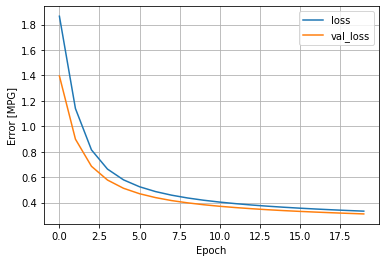

In [5]:
import matplotlib.pyplot as plt
# Get train and test data
trainX, trainY, _, _ = mnist_data()

# Train and checkpoint
model, history = train_mnist(trainX, trainY)
plot_loss(history)

In [6]:
def influence(expl_x, 
              expl_y, 
              refe_x, 
              refe_y, 
              mpath, 
              model, 
              eta,
              num_epochs,
              loss_fn = None):
    """

     - expl_x : explicand features
     - expl_y : explicind labels
     - refe_x : reference features
     - refe_y : reference labels
     - mpath : model path including {} to format epoch iter
     - model : model object for loading weight parameters
     - num_epochs : number of epochs
     - loss_fn : loss function to explain
    
    Returns
     - tracin_sum : measure of influence
        
    """
    # Default to sparse categorical crossentropy
    if not loss_fn:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compute influences
    influence = np.zeros((expl_x.shape[0],refe_x.shape[0]))
    for epoch_iter in range(1,num_epochs+1):
        
        # Load checkpoint
        model.load_weights(mpath.format(epoch_iter))

        # Compute loss gradients for explicands
        expl_grads = []
        for i in range(expl_x.shape[0]):
            with tf.GradientTape() as tape:
                curr_x = expl_x[i:i+1]
                curr_y = expl_y[i:i+1]
                curr_logits = model(curr_x)
                curr_loss   = loss_fn(curr_y, curr_logits)
            expl_grads.append(tape.gradient(curr_loss, model.trainable_variables))

        # Compute loss gradients for references
        refe_grads = []
        for j in range(refe_x.shape[0]):
            with tf.GradientTape() as tape:
                curr_x = refe_x[j:j+1]
                curr_y = refe_y[j:j+1]
                curr_logits = model(curr_x)
                curr_loss   = loss_fn(curr_y, curr_logits)
            refe_grads.append(tape.gradient(curr_loss, model.trainable_variables))

        # Accumulate sum of gradient dot products
        for i in range(len(expl_grads)):
            expl_grad = expl_grads[i]
            for j in range(len(refe_grads)):
                refe_grad = refe_grads[j]
                for k in range(len(expl_grad)):
                    influence[i,j] += eta*reduce_sum(expl_grad[k]*refe_grad[k])
            
    return(influence)

In [7]:
# Get train and test data
train_X,train_Y,test_X,test_Y = mnist_data()

# Form model
eta = 0.001
model = load_mnist(is_compile=False)

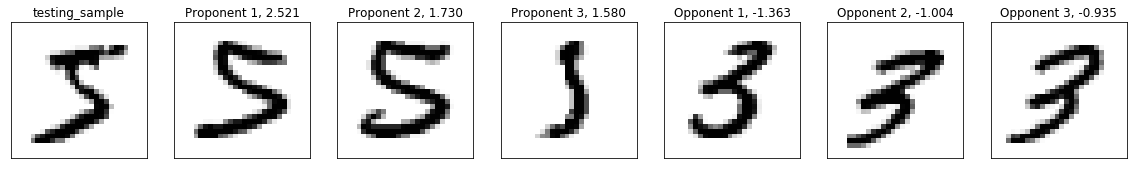

In [11]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.math import reduce_sum

# Calculate influences
influences = influence(train_X[0:1], train_Y[0:1], 
                       train_X[0:1000], train_Y[0:1000], 
                       "model/mnist/model{}.hdf5",
                       model, eta, 20)

# Number of proponents and opponents to plot
k = 3

# Plotting setup
plt.rcParams["figure.figsize"] = (20,3)
num_images = 1+k*2
img_index  = 1

# Display the first digit
plt.subplot(1,num_images,img_index)
plt.imshow(train_X[0].reshape(28,28), cmap=plt.cm.gray_r)
plt.xticks([]); plt.yticks([])
plt.title("testing_sample")
img_index += 1

top_k = influences.argsort()[0][-k:]
for i in range(k):
    plt.subplot(1,num_images,img_index)
    plt.imshow(train_X[top_k[k-(i+1)]].reshape(28,28), cmap=plt.cm.gray_r)
    plt.xticks([]); plt.yticks([])
    plt.title("Proponent {}, {:.3f}".format(i+1, influences[0,top_k[k-(i+1)]]))
    img_index += 1

bot_k = influences.argsort()[0][:k]
for i in range(k):
    plt.subplot(1,num_images,img_index)
    plt.imshow(train_X[bot_k[i]].reshape(28,28), cmap=plt.cm.gray_r)
    plt.xticks([]); plt.yticks([])
    plt.title("Opponent {}, {:.3f}".format(i+1, influences[0,bot_k[i]]))
    img_index += 1

plt.show()